# Structured Representations

This model shows a method for constructing structured representations using semantic
pointers (high dimensional vector representations). It uses a convolution network to
bind two semantic pointers and a summation network to cojoin two semantic pointers.

**Note**: This model can be simplified if built using the SPA (Semantic Pointer
Architecture) package in Nengo 2.0. This method is shown in the last few sections of
this notebook.

In [1]:
# Setup the environment
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import nengo
from nengo.spa import Vocabulary

## Create the Model
This model has parameters as described in the book, with the ensembles having 20
dimensions and 300 neurons each. You will use the `nengo.networks.CircularConvolution`
class in Nengo 2.0 to compute the convolution (or binding) of two semantic pointers
**A**
and **B**.

Since the collection of named vectors in a space forms a kind of "vocabulary" as
described in the book, you will create a vocabulary to build structured representations
out of it.

In [2]:
dim = 20  # Number of dimensions
n_neurons = 300  # Number of neurons in each ensemble

# Creating a vocabulary
rng = np.random.RandomState(0)
vocab = Vocabulary(dimensions=dim, rng=rng)

# Create the network object to which we can add ensembles, connections, etc.
model = nengo.Network(label="Structured Representation")
with model:
    # Input - Get the raw vectors for the pointers using `vocab['A'].v`
    input_A = nengo.Node(output=vocab["A"].v, label="Input A")
    input_B = nengo.Node(output=vocab["B"].v, label="Input B")

    # Ensembles with 300 neurons and 20 dimensions
    # Represents input_A
    ens_A = nengo.Ensemble(n_neurons, dimensions=dim, label="A")
    # Represents input_B
    ens_B = nengo.Ensemble(n_neurons, dimensions=dim, label="B")

    # Represents the convolution of A and B
    ens_C = nengo.Ensemble(n_neurons, dimensions=dim, label="C")
    # Represents the sum of A and B
    ens_sum = nengo.Ensemble(n_neurons, dimensions=dim, label="Sum")

    # Creating the circular convolution network with 70 neurons per dimension
    net_bind = nengo.networks.CircularConvolution(70, dimensions=dim, label="Bind")

    # Connecting the input to ensembles A and B
    nengo.Connection(input_A, ens_A)
    nengo.Connection(input_B, ens_B)

    # Projecting ensembles A and B to the Bind network
    nengo.Connection(ens_A, net_bind.A)
    nengo.Connection(ens_B, net_bind.B)
    nengo.Connection(net_bind.output, ens_C)

    # Projecting ensembles A and B to the Sum ensemble
    nengo.Connection(ens_A, ens_sum)
    nengo.Connection(ens_B, ens_sum)

## Add Probes to Collect Data

Anything that is probed will collect the data it produces over time, allowing you to
analyze and visualize it later.

In [3]:
with model:
    A_probe = nengo.Probe(ens_A, synapse=0.03)
    B_probe = nengo.Probe(ens_B, synapse=0.03)
    C_probe = nengo.Probe(ens_C, synapse=0.03)
    Sum_probe = nengo.Probe(ens_sum, synapse=0.03)

In [4]:
# Set `C` to equal the convolution of `A` with `B` in the vocabulary.
# This will be your ground-truth to test the accuracy of the neural network.
vocab.add("C", vocab.parse("A * B"))

## Run the Model

In order to run the model without `nengo_gui`, you have to create a Nengo simulator.
Then, you
can run that simulator over and over again without affecting the original model.

In [5]:
with nengo.Simulator(model) as sim:  # Create the simulator
    sim.run(1.0)  # Run it for one second

## Plot the Results

Text(0.5, 1.0, 'C (convolution)')

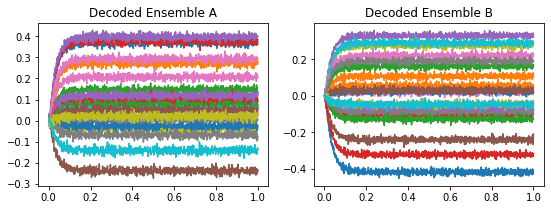

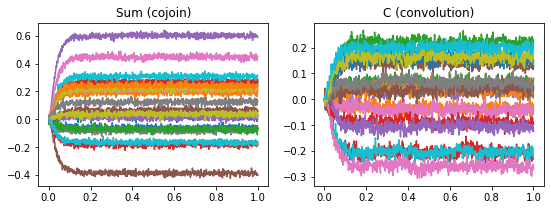

In [6]:
plt.figure(figsize=(14, 3))
plt.subplot(1, 3, 1)
plt.plot(sim.trange(), sim.data[A_probe])
plt.title("Decoded Ensemble A")

plt.subplot(1, 3, 2)
plt.plot(sim.trange(), sim.data[B_probe])
plt.title("Decoded Ensemble B")

plt.figure(figsize=(14, 3))
plt.subplot(1, 3, 1)
plt.plot(sim.trange(), sim.data[Sum_probe])
plt.title("Sum (cojoin)")

plt.subplot(1, 3, 2)
plt.plot(sim.trange(), sim.data[C_probe])
plt.title("C (convolution)")

The graphs above show the value of individual components of their respective ensembles.
They show the same information as the "value" graphs in the Interactive Plots in Nengo
1.4 GUI as described in the book.

## Analyze the results

The Interactive Plots in Nengo 1.4 GUI can also be used to see the "Semantic Pointer"
graph of an ensemble as described in the book. You can create similarity graphs to get
the same information by plotting the similarity between the semantic pointer represented
by an ensemble and all the semantic pointers in the vocabulary. The dot product is a
common measure of similarity between semantic pointers, since it approximates the cosine
similarity when the semantic pointer lengths are close to one.

For this model, you can plot the exact convolution of the semantic pointers **A** and
**B** (given by
`vocab.parse('A * B')`), and the result of the neural convolution (given by
`sim.data[C_probe]`).

Both the dot product and the exact cosine similarity can be computed with
`nengo.spa.similarity`. Normally, this function will compute the dot product, but
setting `normalize=True` normalizes all vectors so that the exact cosine similarity is
computed instead.

Text(0, 0.5, 'dot product')

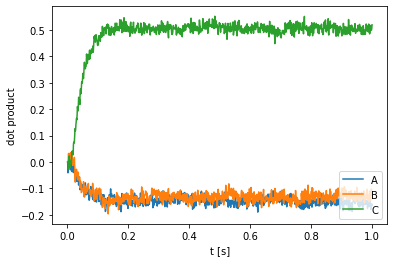

In [7]:
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[C_probe], vocab))
plt.legend(vocab.keys, loc=4)
plt.xlabel("t [s]")
plt.ylabel("dot product")

The above plot shows that the neural output is much closer to `C = A * B` than to either
`A` or `B`, suggesting that the network is correctly computing the convolution. The dot
product between the neural output and `C` is not exactly one due in large part to the
fact that the length of `C` is not exactly one. Using cosine similarity, this magnitude
difference can be neglected.

Text(0, 0.5, 'cosine similarity')

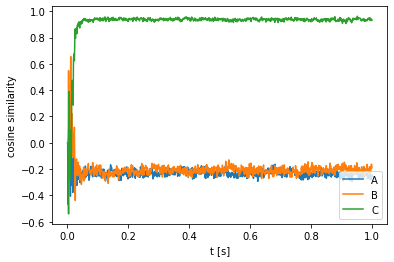

In [8]:
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[C_probe], vocab, normalize=True))
plt.legend(vocab.keys, loc=4)
plt.xlabel("t [s]")
plt.ylabel("cosine similarity")

You can see that the cosine similarity between the neural output vectors and `C` is
almost exactly one, demonstrating that the neural population is quite accurate in
computing the convolution.

## Create the model using the `nengo.spa` package

Now we will build this model again, using the `nengo.spa`
package built into Nengo 2.0. You will see that using the `spa` package considerably
simplifies model construction and visualization through `nengo_gui`.

In [9]:
from nengo import spa

dim = 32  # the dimensionality of the vectors

# Creating a vocabulary
rng = np.random.RandomState(0)
vocab = Vocabulary(dimensions=dim, rng=rng)
vocab.add("C", vocab.parse("A * B"))

# Create the spa.SPA network to which we can add SPA objects
model = spa.SPA(label="structure", vocabs=[vocab])
with model:
    model.A = spa.State(dim)
    model.B = spa.State(dim)
    model.C = spa.State(dim, feedback=1)
    model.Sum = spa.State(dim)

    actions = spa.Actions("C = A * B", "Sum = A", "Sum = B")

    model.cortical = spa.Cortical(actions)

    # Model input
    model.input = spa.Input(A="A", B="B")

## Run the model in nengo_gui

Import the `nengo_gui` visualizer to run and visualize the model.

In [ ]:
from nengo_gui.ipython import IPythonViz

IPythonViz(model, "ch4-structure.py.cfg")

Press the play button in the visualizer to run the simulation. You should see the
"Semantic pointer cloud" graphs as shown in the figure below.

The graphs `A` and `B` show the semantic pointer representations in objects **A** and
**B**
respectively. Graphs labelled `C` show the result of the convolution operation (left:
shows the semantic pointer representation in object `C`, right: shows the similarity
with the vectors in the vocabulary). The graphs labelled `Sum` show the sum of A and B
as represented by the object `Sum` (left: shows the semantic pointer representation in
Sum, right: shows high similarity with vectors **A** and **B**).

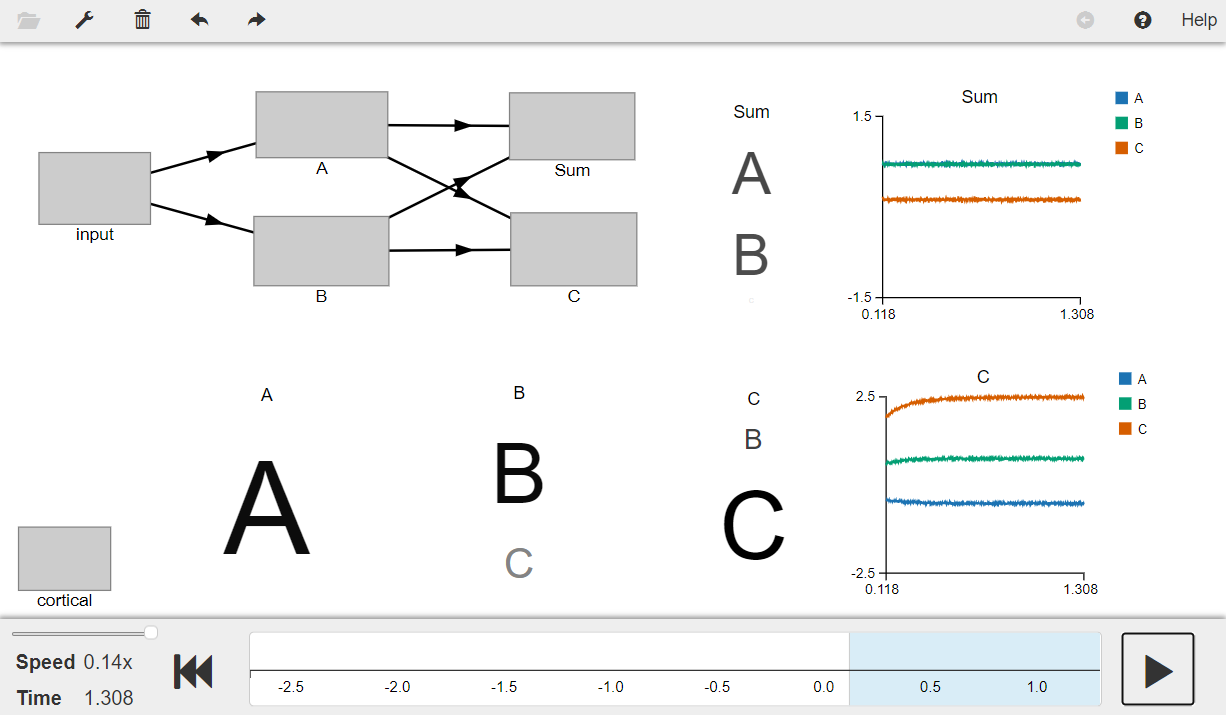

In [10]:
from IPython.display import Image

Image(filename="ch4-structure.png")